In [1]:
# Importing the general utility libraries
import numpy as np
import pandas as pd
import os
import random
import math
import shutil
import os.path
import time
import matplotlib.pyplot as plt

In [2]:
# Importing the TensorFlow libraries for transfer-learning, data augmentation, and fine-tuning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

The graph_training_history function provides plotting of the accuracy and loss of each iteration of the training using the history object returned by the tensorflow training functions. If a validation dataset is used while training, this function can plot both the training and validation graphs.

The subplot function of Matplotlib is used to create a 2-row by 1-column chart to display both the accuracy and loss in the same image.

In [3]:
def graph_training_history(history, save_fig=False, save_path=None, graph_name=""):
    plt.rcParams["figure.figsize"] = (12, 9)

    plt.style.use('ggplot')

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(graph_name + ' Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(graph_name + ' Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.tight_layout()

    if save_fig:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    # clear and close the current figure
    plt.clf()
    plt.close()

The get_class_weights function calculates the class weights by the number of images in each class of the dataset, and provides a higher weight to classes with lower number of images.

When the number of samples (images) are not the same in each of the classes of dataset, it can cause the model to be inaccurate to the larger class. To prevent this, equal weights to the classes can be provided.

In [4]:
def get_class_weights(class_data_dir):
    labels_count = dict()
    for img_class in [ic for ic in os.listdir(class_data_dir) if ic[0] != '.']:
        labels_count[img_class] = len(os.listdir(os.path.join(class_data_dir, img_class)))
    total_count = sum(labels_count.values())
    class_weights = {cls: total_count / count for cls, count in 
                    enumerate(labels_count.values())}
    return class_weights

Below row includes making of the 'working' directories for the model files. 'working' directory used for saving any outputs during model training. 'checkpoint' is used to save temporary snapshots of the model during training. it gets removed after training the 'models' directory is used to save the final model files during its training.

In [5]:
# creating the working directories for the model files
os.makedirs('./working/models', exist_ok = True)

os.makedirs('./working/checkpoints', exist_ok = True)
os.makedirs('./working/checkpoints/training', exist_ok = True)
os.makedirs('./working/checkpoints/finetune', exist_ok = True)

In [6]:
#  defining the paths for the model files
class_indices_path = './working/models/class_indices.npy'
initial_model_path = './working/models/ResNet50_initial.h5'
final_model_path = './working/models/ResNet50_final.h5'

In [7]:
training_checkpoint_dir = './working/checkpoints/training'
finetune_checkpoint_dir = './working/checkpoints/finetune'

init_epoch_train = 0
init_epoch_finetune = 0

In [8]:
# start time of the script
start_time = time.time()

# dimensions of the images.
img_width, img_height = 224, 224

train_data_dir = './input/pneumonia-detection/train'
validation_data_dir = './input/pneumonia-detection/test'

# number of epochs to train
epochs = 50

# batch size used by flow_from_directory
batch_size = 32

Using the ImageDataGenerator class to load and preprocess the dataset. ImageDataGenerator allows on- the-fly data augmentation. Augmentation is applying random transformations to the images so that the model being trained is less likely to overfit. The random transformations prevents the model from seeing the exact same image multiple times during training epochs, which allows the model to gereralize better.

Once the augmentation parameters are defined, the flow_from_directory function can be used to load the images as batches.


In [9]:
# following augmentation configuration will be used for training

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

# augmentation configuration that will be used for testing: 
# rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# the number of classes/categories
num_classes = len(train_generator.class_indices)

# save the class indices for use in the predictions
np.save(class_indices_path, train_generator.class_indices)

# calculating the training steps
nb_train_samples = len(train_generator.filenames)
train_steps = int(math.ceil(nb_train_samples / batch_size))

# calculating the validation steps
nb_validation_samples = len(validation_generator.filenames)
validation_steps = int(math.ceil(nb_validation_samples / batch_size))

# getting the class weights
class_weights = get_class_weights(train_data_dir)

print(class_weights)

{0: 1.3460645161290323, 1: 3.889634601043997}


In order to perform transfer learning on the dataset, a pre-trained CNN model, such as InceptionV3, with the imagenet weights and remove the top dense layers.A new set of dense layers to the model is added. Once these layers are added, the orginal model layers are frozen (i.e. set trainable to false) so that only the new layers will be trained.

In [11]:
# creating the base pre-trained model
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_tensor=Input(shape=(img_width, img_height, 3))
    )

x = base_model.output

# adding a global spatial average pooling layer

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# the model that will be trained

model = Model(inputs=base_model.input, outputs=predictions)

for i,layer in enumerate(model.layers):
    print(i,layer.name)

# first: only the top layers are trained (which were randomly initialized) 
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compiling the model (should be done *after* setting layers to non-trainable)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

filepath = training_checkpoint_dir + "/model-{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.h5"

# saving chackpoints of the model training as it allows to load the best stage of the training after the training is finished

checkpoint = ModelCheckpoint(
                            filepath, 
                            monitor="val_acc", 
                            verbose=1, 
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode="max"
                            )

# early stopping can monitor the model training and will stop the training 
#if the validation accuracy does not improve for more than 10 epochs. 
#It will also restore the best model weights using the checkpoints saved above.
early_stop = EarlyStopping(
                            monitor="val_acc", 
                            mode="max", 
                            verbose=1, 
                            patience=10, 
                            restore_best_weights=True
                            )

# reduce learning-rate can detect if the training is not improving, 
# and will automatically reduce the rearning rate to 1/10 to reduce overfitting.
reduce_lr = ReduceLROnPlateau(
                            monitor='val_acc',
                            mode="max",
                            patience=3,
                            verbose=1
                            )

callbacks_list = [checkpoint, reduce_lr, early_stop]

# training the model, and getting back the history object to graph

history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    class_weight=class_weights,
                    max_queue_size=15,
                    workers=8,
                    initial_epoch=init_epoch_train,
                    callbacks=callbacks_list
                    )

# saving the model to file
model.save(initial_model_path)

# running evaluation on the model
(eval_loss, eval_accuracy) = model.evaluate(
    validation_generator, steps=validation_steps)

print("\n")

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

94773248/94765736 [==============================] - 0s 0us/step
0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv

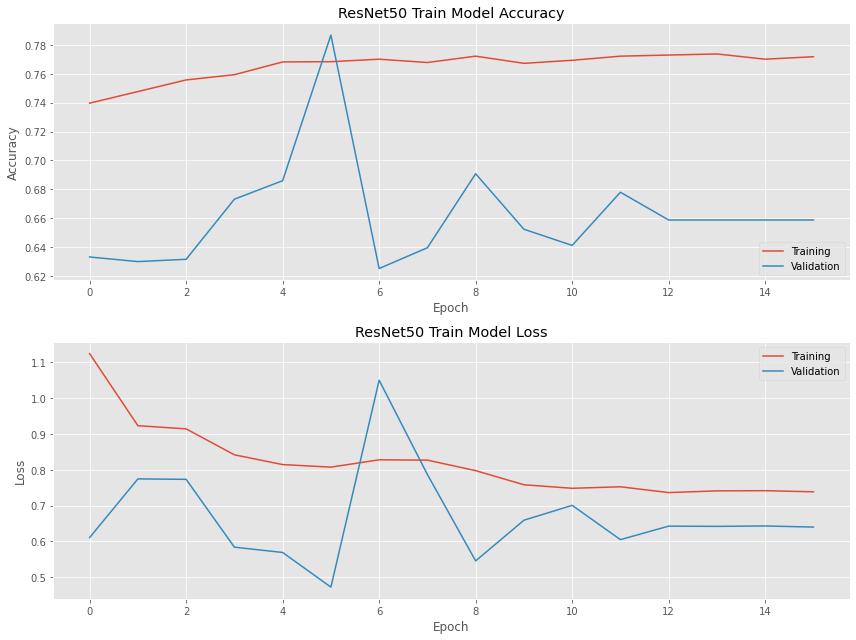

In [12]:
# plotting the training history
graph_training_history(history, save_fig=False, graph_name="ResNet50 Train")

In order to fine-tune the transfer-learned model, the model is unfreezed up to the last convolutional block of the model.

it can then bed trained using a very low learning rate.

In [13]:
# number of epochs to fine-tune
ft_epochs = 50

# resetting the data generators
train_generator.reset()
validation_generator.reset()

# the last convolution block from the base model was chosen to be trained

for layer in model.layers[:165]:
    layer.trainable = False
for layer in model.layers[165:]:
    layer.trainable = True


# recompiling the model for these modifications to take effect 
# SGD with a low learning rate was used
model.compile(
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
    loss='categorical_crossentropy', 
    metrics=['acc']
    )

filepath = finetune_checkpoint_dir + "/model-{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.h5"

checkpoint = ModelCheckpoint(
                            filepath, 
                            monitor="val_acc", 
                            verbose=1, 
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode="max"
                            )

early_stop = EarlyStopping(
                            monitor="val_acc", 
                            mode="max", 
                            verbose=1, 
                            patience=10, 
                            restore_best_weights=True
                            )

reduce_lr = ReduceLROnPlateau(
                            monitor='val_acc',
                            mode="max",
                            patience=3,
                            verbose=1
                            )

callbacks_list = [checkpoint, reduce_lr, early_stop]

history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps,
                    epochs=ft_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    class_weight=class_weights,
                    max_queue_size=15,
                    workers=8,
                    initial_epoch=init_epoch_finetune,
                    callbacks=callbacks_list
                    )

model.save(final_model_path)

(eval_loss, eval_accuracy) = model.evaluate(
    validation_generator, steps=validation_steps)

print("\n")

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

Epoch 1/50
163/163 [==============================] - 113s 651ms/step - loss: 1.1562 - acc: 0.7889 - val_loss: 0.7928 - val_acc: 0.6266

Epoch 00001: val_acc improved from -inf to 0.62660, saving model to ./working/checkpoints/finetune/model-01-0.63-0.79.h5
Epoch 2/50
163/163 [==============================] - 107s 632ms/step - loss: 0.6453 - acc: 0.8040 - val_loss: 0.5044 - val_acc: 0.6699

Epoch 00002: val_acc improved from 0.62660 to 0.66987, saving model to ./working/checkpoints/finetune/model-02-0.67-0.50.h5
Epoch 3/50
163/163 [==============================] - 107s 630ms/step - loss: 0.5985 - acc: 0.8297 - val_loss: 0.8026 - val_acc: 0.6426

Epoch 00003: val_acc did not improve from 0.66987
Epoch 4/50
163/163 [==============================] - 109s 624ms/step - loss: 0.6311 - acc: 0.8328 - val_loss: 1.7638 - val_acc: 0.6250

Epoch 00004: val_acc did not improve from 0.66987
Epoch 5/50
163/163 [==============================] - 109s 628ms/step - loss: 0.6114 - acc: 0.8351 - val_lo

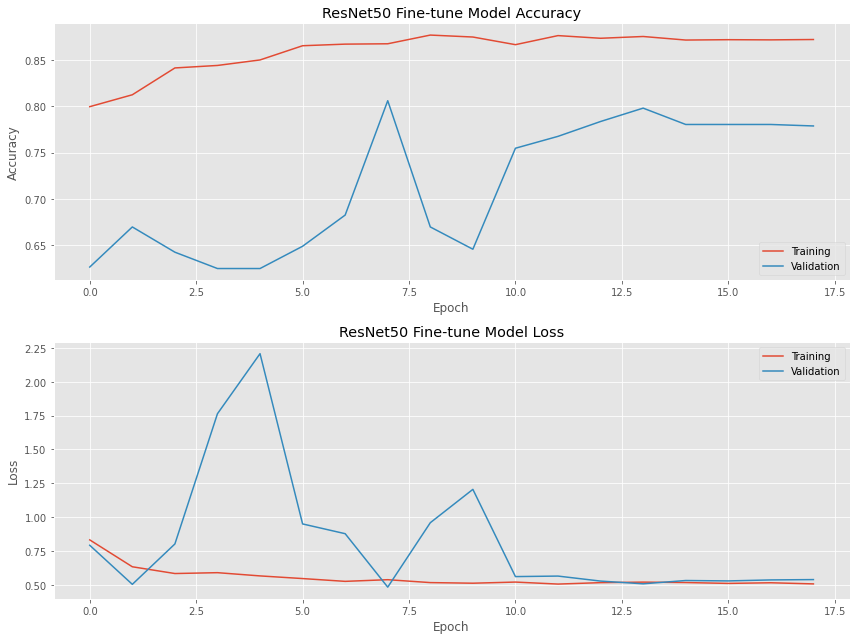

In [14]:
graph_training_history(history, save_fig=False, graph_name="ResNet50 Fine-tune")

In [15]:
end_time = time.time()

training_duration = end_time - start_time
print("[INFO] Total Time for training: {} seconds".format(training_duration))

[INFO] Total Time for training: 3765.8523602485657 seconds


In [16]:
# Cleaning up the checkpoints directory
shutil.rmtree('./working/checkpoints')